## 7005 Personality：

### mbti介绍：
1. 理论来源
2. 举个栗子
3. 数据集介绍

### 描述性统计：
1. 数据集各个分型占的比例 vs 总体比例
2. 数据集中各个分型的词云图展示

### 数据清洗 & 特征工程：
1. 去除链接
2. 去除特殊字符
3. 文本转换为小写字符
4. 文本分割
5. 去除停用词
6. 词型还原
7. tf-idf

### 模型拟合
1. 基准模型：逻辑回归
2. 集成学习：XGboost
3. LSTM：深度学习
4. BERT（预训练语言模型）

### 结果比较与输出

## 正文

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Attention, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

## Data Cleaning Process

In [29]:
mbti = pd.read_csv('mbti_1.csv') # Read datasets
print(mbti.head(5))              # Examine the first five rows of the dataset

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [24]:
print(mbti.describe())           # View Basic Information

        type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'It has been too long since I have been on per...
freq    1832                                                  1


In [25]:
print(mbti.isna().sum())         # Check for missing values

type     0
posts    0
dtype: int64


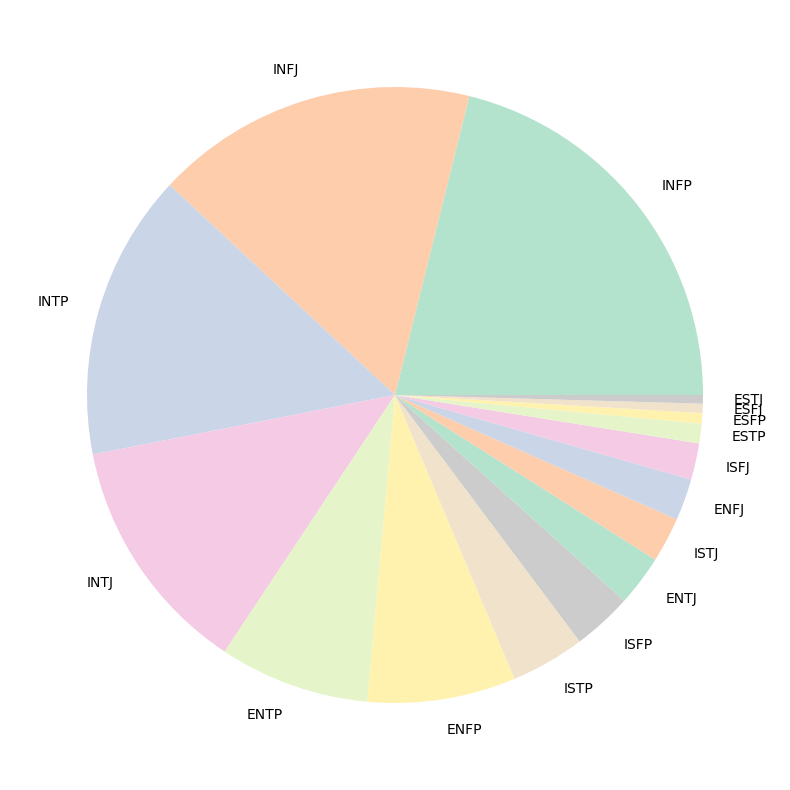

In [26]:
mbti_dict = mbti['type'].value_counts().to_dict()            # As this task is a classification task
mbti = list(mbti_dict.keys())                                # it is necessary to examine the category proportions.
vals = list(mbti_dict.values())                              # using to_dict() to create an dict 

fig, ax = plt.subplots(1,1,figsize = (10,10))                # Create a figure and an axes object, and set the canvas size.
plt.pie(vals, labels = mbti, colors = plt.cm.Pastel2.colors)
plt.show()

In [30]:
# The dataset exhibits sixteen distinct categories with severe class imbalance.
# We intend to fit four classifiers based on the four dimensions of the MBTI theory, rather than undertaking a sixteen-class classification task.
mbti = pd.read_csv('mbti_1.csv')
# Assign a 0-1 encoding to each dimension within the MBTI theory
mbti['Type_I vs E'] = mbti['type'].apply(lambda x:1 if x[0] == 'I' else 0)
mbti['Type_N vs S'] = mbti['type'].apply(lambda x:1 if x[1] == 'N' else 0)
mbti['Type_F vs T'] = mbti['type'].apply(lambda x:1 if x[2] == 'F' else 0)
mbti['Type_P vs J'] = mbti['type'].apply(lambda x:1 if x[3] == 'P' else 0)
print(mbti.head(5))

   type                                              posts  Type_I vs E  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            1   
1  ENTP  'I'm finding the lack of me in these posts ver...            0   
2  INTP  'Good one  _____   https://www.youtube.com/wat...            1   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...            1   
4  ENTJ  'You're fired.|||That's another silly misconce...            0   

   Type_N vs S  Type_F vs T  Type_P vs J  
0            1            1            0  
1            1            0            1  
2            1            0            1  
3            1            0            0  
4            1            0            0  


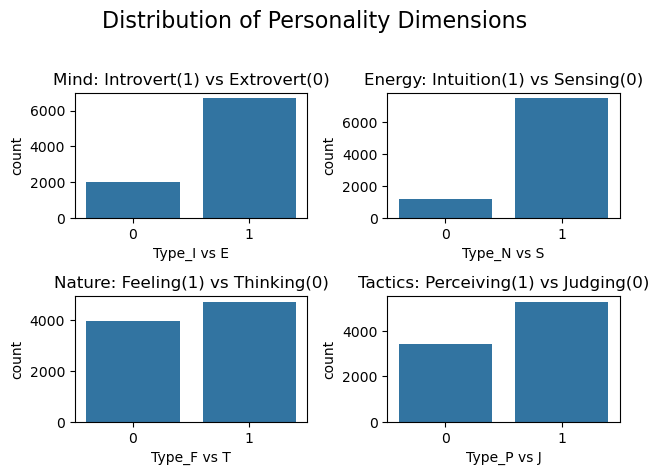

In [8]:
# Examine the proportion of categories across different dimensions following encoding.
fig,axes = plt.subplots(2,2)
fig.suptitle('Distribution of Personality Dimensions', fontsize=16)

# Here, we used the seaborn package which contains numerous user-friendly, pre-configured plotting functions
sns.countplot(x='Type_I vs E', data=mbti, ax=axes[0, 0]).set_title('Mind: Introvert(1) vs Extrovert(0)')
sns.countplot(x='Type_N vs S', data=mbti, ax=axes[0, 1]).set_title('Energy: Intuition(1) vs Sensing(0)')
sns.countplot(x='Type_F vs T', data=mbti, ax=axes[1, 0]).set_title('Nature: Feeling(1) vs Thinking(0)')
sns.countplot(x='Type_P vs J', data=mbti, ax=axes[1, 1]).set_title('Tactics: Perceiving(1) vs Judging(0)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 两个维度比例差别太大，后续进行处理

#### 原数据集文本中噪声过多，需要去除噪声

In [31]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')             Please execute this comment during the initial run.
# nltk.download('wordnet')               Please execute this comment during the initial run.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [32]:
# Here we define a function to clean the text columns in the dataset.
def clean_text(text:str):
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)                 # Clearing URLs using regular expressions
    text = re.sub(r'\|\|\|', ' ', text)                                                     # Remove the separator in the middle of the post
    text = re.sub(r'[^a-zA-Z\s]', '', text)                                                 # Remove special characters from within the text
    text = text.lower()                                                                     # Lowercase conversion
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words] # stemming and stopword removal
    return " ".join(words)

# Apply the text cleaning function defined earlier to the text columns using the pandas apply() method.
mbti['cleaned_posts'] = mbti['posts'].apply(clean_text)
print(mbti.head(5))

   type                                              posts  Type_I vs E  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            1   
1  ENTP  'I'm finding the lack of me in these posts ver...            0   
2  INTP  'Good one  _____   https://www.youtube.com/wat...            1   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...            1   
4  ENTJ  'You're fired.|||That's another silly misconce...            0   

   Type_N vs S  Type_F vs T  Type_P vs J  \
0            1            1            0   
1            1            0            1   
2            1            0            1   
3            1            0            0   
4            1            0            0   

                                       cleaned_posts  
0  intj moment sportscenter top ten play prank li...  
1  im finding lack post alarming sex boring posit...  
2  good one course say know thats blessing curse ...  
3  dear intp enjoyed conversation day esoteric ga...  
4  youre 

#### 训练模型
> 由于人格分型过多(16种)，针对每一种算法，采用维度分类建立四个模型，最终合成一个输出
> 
> 根据已经生成的特征矩阵及结果进行训练集和测试集的分割，便于进行交叉验证挑选超参数等
> 
> 针对类别相对平衡的维度，暂不进行采样处理减少工作量，针对类别不平衡的维度进行采样处理
> 
> 使用10折交叉验证拟合最合适的超参数
> 
> 确定模型，并且输出结果
> 

In [33]:
# Training and Test Set Partitioning
from sklearn.model_selection import train_test_split

X = mbti['cleaned_posts']
y_ie = mbti['Type_I vs E']  # I/E Dimension Result Labels
y_ns = mbti['Type_N vs S']  # N/S Dimension Result Labels
y_ft = mbti['Type_F vs T']  # F/T Dimension Result Labels
y_pj = mbti['Type_P vs J']  # P/J Dimension Result Labels

X_train_text, X_test_text, y_ie_train, y_ie_test, y_ns_train, y_ns_test, y_ft_train, y_ft_test, y_pj_train, y_pj_test = train_test_split(
    X, y_ie, y_ns, y_ft, y_pj,
    test_size = 0.2,                 
    random_state = 1010,             # Fix the random seed to ensure partitioning is reproducible
    stratify = y_ie)

# TF-IDF feature engineering using only the training set
from sklearn.feature_extraction.text import TfidfVectorizer
MAX_FEATURES = 5000
vectorizer = TfidfVectorizer(
    max_features = MAX_FEATURES,
    ngram_range = (1, 2))

# Fit the vectoriser using the training set text and convert it into a feature matrix
X_train = vectorizer.fit_transform(X_train_text) 
# Convert the test set text using the vocabulary from the training set
X_test = vectorizer.transform(X_test_text)        

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib

# Instantiate the cross-validation object
strat_kfold = StratifiedKFold(n_splits = 10,
                              shuffle = True,
                              random_state = 42)


# Define model functions
def logistic_regression_model():

    model_baseline = LogisticRegression(  # Baseline Model (No Sampling)
        C = 1.0,
        class_weight='balanced',
        penalty = 'l2',
        max_iter = 1000,
        random_state = 42
    )
    
    model_smote = Pipeline([              # SMOTE Model (Over-sampling Minority Classes)
        ('smote', SMOTE(random_state = 1010, k_neighbors = 5)),
        ('classifier', LogisticRegression(
            C = 1.0,
            penalty = 'l2',
            max_iter = 1000,
            random_state = 42
        ))  
    ])

    return model_baseline, model_smote   # Return two models


# Cross-Validation Evaluation Function
def evaluate_model(model, X, y_np, cv, model_name, label = 0):
    
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 score': []
    }

    for train_idx, val_idx in cv.split(X, y_np):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['Precision'].append(precision_score(y_val, y_pred, pos_label = label))
        metrics['Recall'].append(recall_score(y_val, y_pred, pos_label = label))
        metrics['F1 score'].append(f1_score(y_val, y_pred, pos_label = label))

    # Print result
    print(f"\n===== {model_name} Cross-validation results =====")
    results_df = pd.DataFrame(metrics)
    results_df['Fold number'] = range(1, len(results_df)+1)
    print(results_df[['Fold number', 'Accuracy', 'Precision', 'Recall', 'F1 score']])

    # Average metric
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    print("\nAverage metric：")
    for k, v in avg_metrics.items():
        print(f"{k}：{v}")

    return avg_metrics


# Main Function (Execution Flow)
def main_body(X_train, X_test, y_train, y_test, cv):
    # Convert tags to NumPy arrays
    y_train_np = y_train.values
    y_test_np = y_test.values

    # Retrieve the model
    model_baseline, model_smote = logistic_regression_model()

    # Cross-validation evaluation
    evaluate_model(model_baseline, X_train, y_train_np, cv, "Baseline Model", label = 0)
    evaluate_model(model_smote, X_train, y_train_np, cv, "SMOTE Model", label = 0)

    # Training the final model
    final_model = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(
            C = 1.0,
            penalty = 'l2',
            max_iter = 1000,
            random_state = 1010
        ))
    ])
    final_model.fit(X_train, y_train_np)

    # Test Set Evaluation
    y_final_pred = final_model.predict(X_test)
    print("\n===== Final model test set performance =====")
    test_metrics = {
        'Accuracy': accuracy_score(y_test_np, y_final_pred),
        'Precision': precision_score(y_test_np, y_final_pred, pos_label = 0),
        'Recall': recall_score(y_test_np, y_final_pred, pos_label = 0),
        'F1 score': f1_score(y_test_np, y_final_pred, pos_label = 0)
    }
    for k, v in test_metrics.items():
        print(f"{k}：{v}")

    return final_model  

print("\n===== I/E model result =====")
main_body(X_train, X_test, y_ie_train, y_ie_test, strat_kfold)
print("\n===== N/S model result =====")
main_body(X_train, X_test, y_ns_train, y_ns_test, strat_kfold)
print("\n===== F/T model result =====")
main_body(X_train, X_test, y_ft_train, y_ft_test, strat_kfold)
print("\n===== P/J model result =====")
main_body(X_train, X_test, y_pj_train, y_pj_test, strat_kfold)


===== I/E model result =====

===== Baseline Model Cross-validation results =====
   Fold number  Accuracy  Precision    Recall  F1 score
0            1  0.841499   0.632432  0.735849  0.680233
1            2  0.842939   0.636364  0.743750  0.685879
2            3  0.860231   0.672131  0.768750  0.717201
3            4  0.874640   0.723926  0.737500  0.730650
4            5  0.822767   0.593909  0.731250  0.655462
5            6  0.858790   0.668478  0.768750  0.715116
6            7  0.847262   0.648352  0.737500  0.690058
7            8  0.853026   0.661111  0.743750  0.700000
8            9  0.845821   0.638743  0.762500  0.695157
9           10  0.832853   0.625000  0.687500  0.654762

Average metric：
Accuracy：0.8479827089337176
Precision：0.6500446701976481
Recall：0.7417099056603773
F1 score：0.6924518385049557

===== SMOTE Model Cross-validation results =====
   Fold number  Accuracy  Precision    Recall  F1 score
0            1  0.845821   0.664557  0.660377  0.662461
1          

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=1010))])

### XGboost

In [50]:
! pip install XGboost

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import xgboost as xgb


strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1010)


# XGBoost Model Function
def xgboost_model(y_train_np, label = 0):

    n_minority = np.sum(y_train_np == label)          # Minority class sample size
    n_majority = len(y_train_np) - n_minority         # Majority class sample size
    scale_pos_weight = n_majority / n_minority       


    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'scale_pos_weight': scale_pos_weight,        # Weight-based handling of imbalanced data in baseline models
        'learning_rate': 0.1,
        'max_depth': 5,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
    }

    # Baseline Model
    model_baseline = xgb.XGBClassifier(**xgb_params)

    # SMOTE+XGBoost
    xgb_params_smote = xgb_params.copy()
    xgb_params_smote['scale_pos_weight'] = 1  

    model_smote = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(** xgb_params_smote))
    ])

    return model_baseline, model_smote


# Cross-Validation
def evaluate_model(model, X, y_np, cv, model_name, label=0):
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 score': []
    }

    for train_idx, val_idx in cv.split(X, y_np):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['Precision'].append(precision_score(y_val, y_pred, pos_label=label))
        metrics['Recall'].append(recall_score(y_val, y_pred, pos_label=label))
        metrics['F1 score'].append(f1_score(y_val, y_pred, pos_label=label))

    # Print result
    print(f"\n===== {model_name} Cross-validation results =====")
    results_df = pd.DataFrame(metrics)
    results_df['Fold number'] = range(1, len(results_df)+1)
    print(results_df[['Fold number', 'Accuracy', 'Precision', 'Recall', 'F1 score']])

    # Average metric
    avg_metrics = {k: np.mean(v).round(4) for k, v in metrics.items()}
    print("\nAverage metric：")
    for k, v in avg_metrics.items():
        print(f"{k}：{v}")

    return avg_metrics


# main function
def main_body(X_train, X_test, y_train, y_test, cv, label = 0):
    
    # Convert tags to NumPy arrays
    y_train_np = y_train.values
    y_test_np = y_test.values

    # Retrieve the model
    model_baseline, model_smote = xgboost_model(y_train_np, label = 0)

    # Cross-validation evaluation
    evaluate_model(model_baseline, X_train, y_train_np, cv, 
                  "XGBoost only", label = 0)
    evaluate_model(model_smote, X_train, y_train_np, cv, 
                  "XGBoost+SMOTE", label = 0)

    # Training the final model
    final_model = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(
            objective = 'binary:logistic',
            eval_metric = 'logloss',
            scale_pos_weight = 1,  
            learning_rate = 0.1,
            max_depth = 5,
            n_estimators = 200,
            subsample = 0.8,
            colsample_bytree = 0.8,
            random_state = 1010,
        ))
    ])
    final_model.fit(X_train, y_train_np)

    # Test Set Evaluation
    y_final_pred = final_model.predict(X_test)
    print("\n===== Final model test set performance =====")
    test_metrics = {
        'Accuracy': accuracy_score(y_test_np, y_final_pred),
        'Precision': precision_score(y_test_np, y_final_pred, pos_label = 0),
        'Recall': recall_score(y_test_np, y_final_pred, pos_label = 0),
        'F1 score': f1_score(y_test_np, y_final_pred, pos_label = 0)
    }
    for k, v in test_metrics.items():
        print(f"{k}：{v}")

    return final_model




print("===== I/E model result =====")
ie_model = main_body(X_train, X_test, y_ie_train, y_ie_test, strat_kfold, label = 0)

print("\n===== N/S model result =====")
ns_model = main_body(X_train, X_test, y_ns_train, y_ns_test, strat_kfold, label = 0)  

print("\n===== F/T model result =====")
ft_model = main_body(X_train, X_test, y_ft_train, y_ft_test, strat_kfold, label = 0)

print("\n===== P/J model result =====")
pj_model = main_body(X_train, X_test, y_pj_train, y_pj_test, strat_kfold, label = 0)

===== I/E model result =====

===== XGBoost only Cross-validation results =====
   Fold number  Accuracy  Precision    Recall  F1 score
0            1  0.841499   0.855072  0.371069  0.517544
1            2  0.834294   0.816901  0.362500  0.502165
2            3  0.840058   0.865672  0.362500  0.511013
3            4  0.847262   0.846154  0.412500  0.554622
4            5  0.824207   0.771429  0.337500  0.469565
5            6  0.854467   0.883117  0.425000  0.573840
6            7  0.838617   0.779070  0.418750  0.544715
7            8  0.853026   0.845238  0.443750  0.581967
8            9  0.845821   0.907692  0.368750  0.524444
9           10  0.821326   0.800000  0.300000  0.436364

Average metric：
Accuracy：0.8401
Precision：0.837
Recall：0.3802
F1 score：0.5216

===== XGBoost+SMOTE Cross-validation results =====
   Fold number  Accuracy  Precision    Recall  F1 score
0            1  0.842939   0.735849  0.490566  0.588679
1            2  0.858790   0.758333  0.568750  0.650000
2    

## Hybrid DL

In [55]:
print(mbti)

      type                                              posts  Type_I vs E  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            1   
1     ENTP  'I'm finding the lack of me in these posts ver...            0   
2     INTP  'Good one  _____   https://www.youtube.com/wat...            1   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...            1   
4     ENTJ  'You're fired.|||That's another silly misconce...            0   
...    ...                                                ...          ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...            1   
8671  ENFP  'So...if this thread already exists someplace ...            0   
8672  INTP  'So many questions when i do these things.  I ...            1   
8673  INFP  'I am very conflicted right now when it comes ...            1   
8674  INFP  'It has been too long since I have been on per...            1   

      Type_N vs S  Type_F vs T  Type_P vs J  \
0               

In [35]:
# A custom LRTensorBoard class has been developed based on Keras' callback mechanism. 
# This class prints the current learning rate (LR) of the model optimiser at the conclusion of each training epoch.
class LRTensorBoard(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f" - Learning Rate: {lr:.6f}")

In [36]:
# Employ ReduceLROnPlateau to monitor the validation set loss. 
# Should it cease decreasing for an extended period, reduce the learning rate to enable the model to converge more precisely in the later stages.
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
# Employ Early Stopping to monitor validation set loss; should it cease decreasing for an extended period, 
# terminate training prematurely to prevent overfitting and conserve time, 
# and simultaneously restoring optimal weights.
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
#  Convert the raw textual data (in this case, the cleaned_posts column of the MBTI dataset) 
# into a numerical sequence that can be processed by deep learning models.

max_words = 10000
maxlen = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(mbti['cleaned_posts'])
sequences = tokenizer.texts_to_sequences(mbti['cleaned_posts'])

X = pad_sequences(sequences, maxlen=maxlen)

In [38]:
X_train, X_test, y_ie_train, y_ie_test, y_ns_train, y_ns_test, y_ft_train, y_ft_test, y_pj_train, y_pj_test = train_test_split(
    X, y_ie, y_ns, y_ft, y_pj,
    test_size = 0.2,                
    random_state = 1010,             
    stratify = y_ie                  
)

In [39]:
# Defining a deep learning model integrating CNN, bidirectional LSTM, and attention mechanisms, 
#The efficacy of this approach has been validated in predicting the Big Five personality traits using digital footprints.

def create_cnn_bilstm_attention():
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=10000, output_dim=128)(inputs)

    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    attn_output = Attention()([x, x])
    x = GlobalAveragePooling1D()(attn_output)

    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [40]:
def main_body(X_train, X_test, y_train, y_test,trait):
    y_train = y_train.values
    y_test = y_test.values
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = dict(enumerate(weights))

    model = create_cnn_bilstm_attention()
    model.compile(loss='binary_crossentropy', optimizer=Adamax(), metrics=['accuracy'])

    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        class_weight=class_weight_dict,
        epochs=30, batch_size=32,
        validation_split=0.2,
        callbacks=[LRTensorBoard(), lr_reduce, early_stop],
        verbose=1
    )

    y_pred_proba = model.predict(X_test)  
    y_final_pred = (y_pred_proba > 0.5).astype("int32").flatten()  

    # Calculate test set metrics (specifying the minority class as pos_label=0)
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_final_pred),
        'Precision': precision_score(y_test, y_final_pred, pos_label=0, zero_division=0),
        'Recall': recall_score(y_test, y_final_pred, pos_label=0, zero_division=0),
        'F1 score': f1_score(y_test, y_final_pred, pos_label=0, zero_division=0)
    }

    # Print Metrics
    print(f"\n===== {trait} Test result =====")
    for k, v in test_metrics.items():
        print(f"{k}：{v:.4f}") 

    return model  

In [41]:
main_body(X_train, X_test, y_ie_train,  y_ie_test,'I/E Hybrid DL')

Epoch 1/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6204 - loss: 0.6863
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5546 - loss: 0.6930 - val_accuracy: 0.2327 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 2/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4214 - loss: 0.6911
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5113 - loss: 0.6928 - val_accuracy: 0.2327 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 3/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6207 - loss: 0.6633
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6763 - loss: 0.6371 - val_accuracy: 0.6110 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 4/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8323 - loss: 0.3928
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8080 - loss: 0.4211 - val_accuracy: 0.7586 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 5/30
 - Learning Rate: 0.

<Functional name=functional, built=True>

In [42]:
main_body(X_train, X_test, y_ns_train,  y_ns_test,'N/S Hybrid DL')

Epoch 1/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4494 - loss: 0.7015
174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5466 - loss: 0.6923 - val_accuracy: 0.8602 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 2/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7203 - loss: 0.6753
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5861 - loss: 0.6913 - val_accuracy: 0.1390 - val_loss: 0.7160 - learning_rate: 0.0010
Epoch 3/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4601 - loss: 0.6587
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6345 - loss: 0.5993 - val_accuracy: 0.7356 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 4/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8570 - loss: 0.3456
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8611 - loss: 0.3536 - val_accuracy: 0.7053 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 5/30
 - Learning Rate: 0.

<Functional name=functional_1, built=True>

In [43]:
main_body(X_train, X_test, y_ft_train,  y_ft_test,'F/T Hybrid DL')

Epoch 1/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5001 - loss: 0.6948
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4935 - loss: 0.6941 - val_accuracy: 0.4597 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5242 - loss: 0.6887
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5643 - loss: 0.6695 - val_accuracy: 0.6095 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 3/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7827 - loss: 0.4784
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7921 - loss: 0.4600 - val_accuracy: 0.6974 - val_loss: 0.6077 - learning_rate: 0.0010
Epoch 4/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8946 - loss: 0.2921
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8820 - loss: 0.3075 - val_accuracy: 0.6707 - val_loss: 0.7739 - learning_rate: 0.0010
Epoch 5/30
 - Learning Rate: 0.

<Functional name=functional_2, built=True>

In [44]:
main_body(X_train, X_test, y_pj_train,  y_pj_test,'P/J Hybrid DL')

Epoch 1/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5198 - loss: 0.6928
174/174 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4924 - loss: 0.6948 - val_accuracy: 0.3869 - val_loss: 0.6981 - learning_rate: 0.0010
Epoch 2/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4522 - loss: 0.6942
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4726 - loss: 0.6945 - val_accuracy: 0.3869 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 3/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4860 - loss: 0.6898
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5452 - loss: 0.6817 - val_accuracy: 0.6362 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 4/30
 - Learning Rate: 0.001000━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7480 - loss: 0.5392
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7480 - loss: 0.5229 - val_accuracy: 0.6578 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 5/30
 - Learning Rate: 0.

<Functional name=functional_3, built=True>